# DRL - Assignment2
## Train a Proximal Policy Optimization (PPO) algorithm on the SpaceInvadersNoFrameskip-v4 
### Yorick Juffer, Alejandro Sánchez Roncero


In [1]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.atari_wrappers import AtariWrapper 
from stable_baselines3.common.monitor import Monitor, ResultsWriter
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, StopTrainingOnNoModelImprovement

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
env_id = 'SpaceInvadersNoFrameskip-v4'
paths = {'log': './logs/', 'monitor': './monitor/', 'model': './models/'}


In [3]:
# Hyperparameters

if False:
    case_id = "01"

    # training - evaluation
    total_timesteps = 1e6 # total number of timesteps
    eval_freq = 5000  # number of timesteps after which the model is evaluated
    n_eval_episodes = 10 # Number of evaluation episodes to estimate its performance
    frame_skip = 4 # Number of skip frames
    # max_no_improvement_evals = 10 # Number of episodes after which the model stops training if there's no improvement

    # model
    learning_rate = 0.0003
    n_steps = 2048
    batch_size = 64
    n_epochs = 10
    gamma = 0.99
    vf_coef = 0.5 
else:
    hyper_params = pd.read_excel("grid_search/{}".format(hyperparams_file))
    
    case_id = str(int(hyper_params["case_id"]))

    # training - evaluation
    total_timesteps = int(hyper_params["total_timesteps"]) # total number of timesteps
    eval_freq = int(hyper_params["eval_freq"])  # number of timesteps after which the model is evaluated
    n_eval_episodes = int(hyper_params["n_eval_episodes"]) # Number of evaluation episodes to estimate its performance
    frame_skip = int(hyper_params["frame_skip"]) # Number of skip frames
    # max_no_improvement_evals = 10 # Number of episodes after which the model stops training if there's no improvement

    # model
    learning_rate = float(hyper_params["learning_rate"])
    n_steps = int(hyper_params["n_steps"])
    batch_size = int(hyper_params["batch_size"])
    n_epochs = int(hyper_params["n_epochs"])
    gamma = float(hyper_params["gamma"])
    vf_coef = float(hyper_params["vf_coef"])
    
    

In [4]:
# Environment:
# - "rgb" -> observation_space=Box(0, 255, (width=210, height=160, channels=3), np.uint8)
# - frameskip=1
# - repeat_prob=0

# Create the environment
env = gym.make(env_id) # difficulty: 0, mode: 0, 6 discrete actions
env = Monitor(env, filename=(paths['monitor']+case_id))

# Resize to a square image: 84x84 by default
# Grayscale observation
# Clip reward to {-1, 0, 1}
env = AtariWrapper(env, frame_skip=frame_skip, action_repeat_probability=0.0) 
env = DummyVecEnv([lambda: env])  # The algorithms require a vectorized environment to run
env = VecFrameStack(env, n_stack=4)  # Stack 4 frames together, to give the agent a sense of motion
env = VecTransposeImage(env)  # Transpose the image to (color_channels, height, width)
env.metadata["render_fps"] = 30

In [5]:
# CNN is more suitable here since Atary games have image-bases observations
start_learning_rate = learning_rate

# linear learning rate
def learning_rate_f(timesteps):
    # Decrease learning rate linearly to 0
    return start_learning_rate * (1 - (timesteps / total_timesteps))

model = PPO("CnnPolicy", env, verbose=0,
            learning_rate=learning_rate_f,
            n_steps=n_steps,
            batch_size=batch_size,
            n_epochs=n_epochs,
            gamma=gamma,
            vf_coef=vf_coef
            )

In [6]:
# Train the agent

# stop_train_callback = StopTrainingOnNoModelImprovement(
#      max_no_improvement_evals=max_no_improvement_evals, 
#      min_evals=5, 
#      verbose=1)

eval_callback = EvalCallback(env, 
                             best_model_save_path=(paths['model']+case_id), 
                             log_path=(paths['log']+case_id),
                             eval_freq=eval_freq,
                             deterministic=True, 
                             render=False,
                         #     callback_after_eval=stop_train_callback, 
                             verbose=0
                        )
model.set_env(env)
model.learn(total_timesteps=total_timesteps, 
            callback=eval_callback,
            progress_bar=True
            )

Output()

In [ ]:
# Evaluate model on n_eval_episodes and calculate the average and std reward
mean_r, std_r = evaluate_policy(model, env, 
                n_eval_episodes=n_eval_episodes,
                deterministic=True,
                return_episode_rewards=False,
                render=False)
print("Evaluation reward: (Avg, Std) -> ({:.2f}, {:.2f})".format(mean_r, std_r))

Evaluation reward: (Avg, Std) -> (417.00, 182.62)


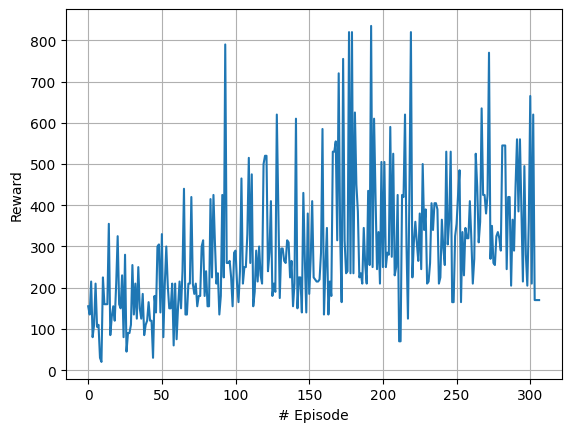

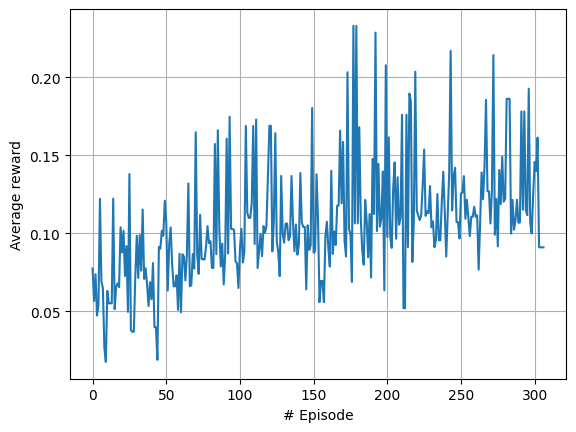

In [ ]:
# Plot the average reward per episode

csv = pd.read_csv("{}{}.monitor.csv".format(paths["monitor"], case_id), sep=",", header=1)

plt.plot(np.array(csv["r"]))
plt.xlabel("# Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()

plt.plot(np.array(csv["r"]) / np.array(csv["l"]))
plt.xlabel("# Episode")
plt.ylabel("Average reward")
plt.grid()

